# Fraud Detection with XGBoost and Triton-FIL

## Introduction
In this example notebook, we will go step-by-step through the process of training and deploying an XGBoost fraud detection model using Triton's new FIL backend. Along the way, we'll show how to analyze the performance of a model deployed in Triton and optimize its performance based on specific SLA targets or other considerations.

While this notebook includes some code to train an XGBoost model, the focus is primarily on how to _use_ that model with Triton. For more general information on XGBoost model training, see the [official XGBoost tutorials](https://xgboost.readthedocs.io/en/stable/tutorials/index.html).

## Pre-Requisites
This notebook assumes that you have Docker and libb64 plus a few Python dependencies. To install all Python dependencies in a conda environment, you may make use of the following conda environment file:
```yaml
---
name: triton_example
channels:
  - conda-forge
  - nvidia
  - rapidsai
dependencies:
  - cudatoolkit=11.4
  - cudf=21.12
  - cuml=21.12
  - cupy
  - jupyter
  - kaggle
  - matplotlib
  - numpy
  - pandas
  - pip
  - python=3.8
  - scikit-learn
  - pip:
      - tritonclient[all]
      - xgboost>=1.5,<1.6
```
The `tritonclient` Python package requires that the libb64 library be available. It is typically installed via the system package manager.

### XGBoost 1.6
Note that due to a change in XGBoost's JSON serialization format, Triton will not be able to load JSON-serialized models from XGBoost 1.6 until Triton version 22.07.

## A Note on Categorical Variables
Categorical variable support was added to the Triton FIL backend in release 21.12 and to XGBoost in release 1.5. If you would like to use an earlier version of either of these or if you simply wish to see how the same workflow would go without explicit categorical variable support, you may set the `USE_CATEGORICAL` variable in the following cell to `False`. Otherwise, by leaving it as `True`, you can take advantage of categorical variable support.

Please note that categorical variable support is still considered experimental in XGBoost 1.5.

In [1]:
USE_CATEGORICAL = True

In [2]:
TRITON_IMAGE = 'nvcr.io/nvidia/tritonserver:21.12-py3'

In [3]:
!docker pull {TRITON_IMAGE}

21.12-py3: Pulling from nvidia/tritonserver
Digest: sha256:b9203002e395af1c2be1a053221bd634f592c5b4f76c069453fc13596c1fc965
Status: Image is up to date for nvcr.io/nvidia/tritonserver:21.12-py3
nvcr.io/nvidia/tritonserver:21.12-py3


## Fetching Training Data
For this example, we will make use of data from the [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection/overview) Kaggle competition. You may fetch the data from this competition using the Kaggle command line client using the following commands.


**NOTE**: You will need to make sure that your Kaggle credentials are [available](https://github.com/Kaggle/kaggle-api#api-credentials) either through a kaggle.json file or via environment variables.

In [4]:
!kaggle competitions download -c ieee-fraud-detection
!unzip -u ieee-fraud-detection.zip
train_csv = 'train_transaction.csv'

ieee-fraud-detection.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ieee-fraud-detection.zip


## Training Example Models
While the IEEE-CIS Kaggle competition focused on a more sophisticated problem involving analysis of both fraudulent transactions and the users linked to those transactions, we will use a simpler version of that problem (identifying fraudulent transactions only) to build our example model. In the following steps, we make use of cuML's preprocessing tools to clean the data and then train two example models using XGBoost. Note that we will be making use of the new categorical feature support in XGBoost 1.5. If you wish to use an earlier version of XGBoost, you will need to perform a [label encoding](https://docs.rapids.ai/api/cuml/stable/api.html?highlight=labelencoder#cuml.preprocessing.LabelEncoder.LabelEncoder) on the categorical features.

In [5]:
import cudf
import cupy as cp
from cuml.preprocessing import SimpleImputer
if not USE_CATEGORICAL:
    from cuml.preprocessing import LabelEncoder
# Due to an upstream bug, cuML's train_test_split function is
# currently non-deterministic. We will therefore use sklearn's
# train_test_split in this example to obtain more consistent
# results.
from sklearn.model_selection import train_test_split

SEED=0

In [6]:
# Load data from CSV files into cuDF DataFrames
data = cudf.read_csv(train_csv)

In [7]:
# Replace NaNs in data
nan_columns = data.columns[data.isna().any().to_pandas()]
float_nan_subset = data[nan_columns].select_dtypes(include='float64')

imputer = SimpleImputer(missing_values=cp.nan, strategy='mean')
data[float_nan_subset.columns] = imputer.fit_transform(float_nan_subset)

obj_nan_subset = data[nan_columns].select_dtypes(include='object')
data[obj_nan_subset.columns] = obj_nan_subset.fillna('UNKNOWN')

In [8]:
# Convert string columns to categorical or perform label encoding
cat_columns = data.select_dtypes(include='object')
if USE_CATEGORICAL:
    data[cat_columns.columns] = cat_columns.astype('category')
else:
    for col in cat_columns.columns:
        data[col] = LabelEncoder().fit_transform(data[col])

In [9]:
# Split data into training and testing sets
X = data.drop('isFraud', axis=1)
y = data.isFraud.astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X.to_pandas(), y.to_pandas(), test_size=0.3, stratify=y.to_pandas(), random_state=SEED
)
# Copy data to avoid slowdowns due to fragmentation
X_train = X_train.copy()
X_test = X_test.copy()

In [10]:
import xgboost as xgb

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [11]:
# Define model training function
def train_model(num_trees, max_depth):
    model = xgb.XGBClassifier(
        tree_method='gpu_hist',
        enable_categorical=USE_CATEGORICAL,
        use_label_encoder=False,
        predictor='gpu_predictor',
        eval_metric='aucpr',
        objective='binary:logistic',
        max_depth=max_depth,
        n_estimators=num_trees
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)]
    )
    return model

In [12]:
# Train a small model with just 500 trees and a maximum depth of 3
small_model = train_model(500, 3)

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

[0]	validation_0-aucpr:0.27398
[1]	validation_0-aucpr:0.31040
[2]	validation_0-aucpr:0.36410
[3]	validation_0-aucpr:0.37392
[4]	validation_0-aucpr:0.38351
[5]	validation_0-aucpr:0.41025
[6]	validation_0-aucpr:0.42383
[7]	validation_0-aucpr:0.43480
[8]	validation_0-aucpr:0.44138
[9]	validation_0-aucpr:0.44549
[10]	validation_0-aucpr:0.45644
[11]	validation_0-aucpr:0.45784
[12]	validation_0-aucpr:0.46026
[13]	validation_0-aucpr:0.46737
[14]	validation_0-aucpr:0.47126
[15]	validation_0-aucpr:0.47544
[16]	validation_0-aucpr:0.47945
[17]	validation_0-aucpr:0.48522
[18]	validation_0-aucpr:0.48962
[19]	validation_0-aucpr:0.49384
[20]	validation_0-aucpr:0.49846
[21]	validation_0-aucpr:0.50069
[22]	validation_0-aucpr:0.50216
[23]	validation_0-aucpr:0.50428
[24]	validation_0-aucpr:0.50755
[25]	validation_0-aucpr:0.51021
[26]	validation_0-aucpr:0.51291
[27]	validation_0-aucpr:0.51642
[28]	validation_0-aucpr:0.51912
[29]	validation_0-aucpr:0.52179
[30]	validation_0-aucpr:0.52363
[31]	validation_0-

[252]	validation_0-aucpr:0.64512
[253]	validation_0-aucpr:0.64540
[254]	validation_0-aucpr:0.64577
[255]	validation_0-aucpr:0.64615
[256]	validation_0-aucpr:0.64633
[257]	validation_0-aucpr:0.64658
[258]	validation_0-aucpr:0.64731
[259]	validation_0-aucpr:0.64755
[260]	validation_0-aucpr:0.64795
[261]	validation_0-aucpr:0.64813
[262]	validation_0-aucpr:0.64826
[263]	validation_0-aucpr:0.64828
[264]	validation_0-aucpr:0.64828
[265]	validation_0-aucpr:0.64848
[266]	validation_0-aucpr:0.64859
[267]	validation_0-aucpr:0.64866
[268]	validation_0-aucpr:0.64882
[269]	validation_0-aucpr:0.64886
[270]	validation_0-aucpr:0.64892
[271]	validation_0-aucpr:0.64907
[272]	validation_0-aucpr:0.64909
[273]	validation_0-aucpr:0.64908
[274]	validation_0-aucpr:0.64923
[275]	validation_0-aucpr:0.64943
[276]	validation_0-aucpr:0.64944
[277]	validation_0-aucpr:0.64938
[278]	validation_0-aucpr:0.64985
[279]	validation_0-aucpr:0.64986
[280]	validation_0-aucpr:0.65038
[281]	validation_0-aucpr:0.65086
[282]	vali

In [13]:
# Train a large model with 5000 trees and a maximum depth of 12
large_model = train_model(5000, 12)

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

[0]	validation_0-aucpr:0.48419
[1]	validation_0-aucpr:0.52474
[2]	validation_0-aucpr:0.55085
[3]	validation_0-aucpr:0.57898
[4]	validation_0-aucpr:0.60050
[5]	validation_0-aucpr:0.62147
[6]	validation_0-aucpr:0.63398
[7]	validation_0-aucpr:0.64841
[8]	validation_0-aucpr:0.65794
[9]	validation_0-aucpr:0.66911
[10]	validation_0-aucpr:0.68038
[11]	validation_0-aucpr:0.68837
[12]	validation_0-aucpr:0.69687
[13]	validation_0-aucpr:0.70616
[14]	validation_0-aucpr:0.71747
[15]	validation_0-aucpr:0.72493
[16]	validation_0-aucpr:0.73362
[17]	validation_0-aucpr:0.73955
[18]	validation_0-aucpr:0.74680
[19]	validation_0-aucpr:0.75048
[20]	validation_0-aucpr:0.75540
[21]	validation_0-aucpr:0.75795
[22]	validation_0-aucpr:0.76367
[23]	validation_0-aucpr:0.76601
[24]	validation_0-aucpr:0.76765
[25]	validation_0-aucpr:0.76912
[26]	validation_0-aucpr:0.77196
[27]	validation_0-aucpr:0.77306
[28]	validation_0-aucpr:0.77383
[29]	validation_0-aucpr:0.77446
[30]	validation_0-aucpr:0.77699
[31]	validation_0-

[252]	validation_0-aucpr:0.83257
[253]	validation_0-aucpr:0.83274
[254]	validation_0-aucpr:0.83295
[255]	validation_0-aucpr:0.83305
[256]	validation_0-aucpr:0.83325
[257]	validation_0-aucpr:0.83333
[258]	validation_0-aucpr:0.83336
[259]	validation_0-aucpr:0.83368
[260]	validation_0-aucpr:0.83385
[261]	validation_0-aucpr:0.83390
[262]	validation_0-aucpr:0.83391
[263]	validation_0-aucpr:0.83388
[264]	validation_0-aucpr:0.83371
[265]	validation_0-aucpr:0.83378
[266]	validation_0-aucpr:0.83389
[267]	validation_0-aucpr:0.83393
[268]	validation_0-aucpr:0.83388
[269]	validation_0-aucpr:0.83400
[270]	validation_0-aucpr:0.83397
[271]	validation_0-aucpr:0.83401
[272]	validation_0-aucpr:0.83400
[273]	validation_0-aucpr:0.83402
[274]	validation_0-aucpr:0.83425
[275]	validation_0-aucpr:0.83442
[276]	validation_0-aucpr:0.83451
[277]	validation_0-aucpr:0.83453
[278]	validation_0-aucpr:0.83458
[279]	validation_0-aucpr:0.83456
[280]	validation_0-aucpr:0.83467
[281]	validation_0-aucpr:0.83460
[282]	vali

[501]	validation_0-aucpr:0.84230
[502]	validation_0-aucpr:0.84232
[503]	validation_0-aucpr:0.84236
[504]	validation_0-aucpr:0.84231
[505]	validation_0-aucpr:0.84233
[506]	validation_0-aucpr:0.84237
[507]	validation_0-aucpr:0.84238
[508]	validation_0-aucpr:0.84237
[509]	validation_0-aucpr:0.84241
[510]	validation_0-aucpr:0.84240
[511]	validation_0-aucpr:0.84242
[512]	validation_0-aucpr:0.84242
[513]	validation_0-aucpr:0.84238
[514]	validation_0-aucpr:0.84242
[515]	validation_0-aucpr:0.84234
[516]	validation_0-aucpr:0.84245
[517]	validation_0-aucpr:0.84245
[518]	validation_0-aucpr:0.84249
[519]	validation_0-aucpr:0.84256
[520]	validation_0-aucpr:0.84264
[521]	validation_0-aucpr:0.84263
[522]	validation_0-aucpr:0.84267
[523]	validation_0-aucpr:0.84262
[524]	validation_0-aucpr:0.84264
[525]	validation_0-aucpr:0.84265
[526]	validation_0-aucpr:0.84268
[527]	validation_0-aucpr:0.84269
[528]	validation_0-aucpr:0.84274
[529]	validation_0-aucpr:0.84275
[530]	validation_0-aucpr:0.84273
[531]	vali

[750]	validation_0-aucpr:0.84473
[751]	validation_0-aucpr:0.84478
[752]	validation_0-aucpr:0.84477
[753]	validation_0-aucpr:0.84482
[754]	validation_0-aucpr:0.84482
[755]	validation_0-aucpr:0.84484
[756]	validation_0-aucpr:0.84483
[757]	validation_0-aucpr:0.84481
[758]	validation_0-aucpr:0.84485
[759]	validation_0-aucpr:0.84483
[760]	validation_0-aucpr:0.84482
[761]	validation_0-aucpr:0.84482
[762]	validation_0-aucpr:0.84484
[763]	validation_0-aucpr:0.84484
[764]	validation_0-aucpr:0.84484
[765]	validation_0-aucpr:0.84486
[766]	validation_0-aucpr:0.84485
[767]	validation_0-aucpr:0.84484
[768]	validation_0-aucpr:0.84485
[769]	validation_0-aucpr:0.84486
[770]	validation_0-aucpr:0.84482
[771]	validation_0-aucpr:0.84481
[772]	validation_0-aucpr:0.84485
[773]	validation_0-aucpr:0.84487
[774]	validation_0-aucpr:0.84488
[775]	validation_0-aucpr:0.84487
[776]	validation_0-aucpr:0.84485
[777]	validation_0-aucpr:0.84486
[778]	validation_0-aucpr:0.84490
[779]	validation_0-aucpr:0.84492
[780]	vali

[999]	validation_0-aucpr:0.84607
[1000]	validation_0-aucpr:0.84607
[1001]	validation_0-aucpr:0.84608
[1002]	validation_0-aucpr:0.84614
[1003]	validation_0-aucpr:0.84613
[1004]	validation_0-aucpr:0.84615
[1005]	validation_0-aucpr:0.84613
[1006]	validation_0-aucpr:0.84615
[1007]	validation_0-aucpr:0.84613
[1008]	validation_0-aucpr:0.84612
[1009]	validation_0-aucpr:0.84612
[1010]	validation_0-aucpr:0.84615
[1011]	validation_0-aucpr:0.84618
[1012]	validation_0-aucpr:0.84617
[1013]	validation_0-aucpr:0.84621
[1014]	validation_0-aucpr:0.84620
[1015]	validation_0-aucpr:0.84622
[1016]	validation_0-aucpr:0.84618
[1017]	validation_0-aucpr:0.84620
[1018]	validation_0-aucpr:0.84623
[1019]	validation_0-aucpr:0.84622
[1020]	validation_0-aucpr:0.84620
[1021]	validation_0-aucpr:0.84623
[1022]	validation_0-aucpr:0.84624
[1023]	validation_0-aucpr:0.84624
[1024]	validation_0-aucpr:0.84625
[1025]	validation_0-aucpr:0.84624
[1026]	validation_0-aucpr:0.84625
[1027]	validation_0-aucpr:0.84624
[1028]	validati

[1240]	validation_0-aucpr:0.84635
[1241]	validation_0-aucpr:0.84636
[1242]	validation_0-aucpr:0.84636
[1243]	validation_0-aucpr:0.84637
[1244]	validation_0-aucpr:0.84638
[1245]	validation_0-aucpr:0.84639
[1246]	validation_0-aucpr:0.84637
[1247]	validation_0-aucpr:0.84637
[1248]	validation_0-aucpr:0.84639
[1249]	validation_0-aucpr:0.84639
[1250]	validation_0-aucpr:0.84638
[1251]	validation_0-aucpr:0.84638
[1252]	validation_0-aucpr:0.84636
[1253]	validation_0-aucpr:0.84640
[1254]	validation_0-aucpr:0.84639
[1255]	validation_0-aucpr:0.84640
[1256]	validation_0-aucpr:0.84637
[1257]	validation_0-aucpr:0.84641
[1258]	validation_0-aucpr:0.84639
[1259]	validation_0-aucpr:0.84639
[1260]	validation_0-aucpr:0.84638
[1261]	validation_0-aucpr:0.84637
[1262]	validation_0-aucpr:0.84635
[1263]	validation_0-aucpr:0.84638
[1264]	validation_0-aucpr:0.84640
[1265]	validation_0-aucpr:0.84639
[1266]	validation_0-aucpr:0.84641
[1267]	validation_0-aucpr:0.84641
[1268]	validation_0-aucpr:0.84641
[1269]	validat

[1481]	validation_0-aucpr:0.84673
[1482]	validation_0-aucpr:0.84674
[1483]	validation_0-aucpr:0.84672
[1484]	validation_0-aucpr:0.84670
[1485]	validation_0-aucpr:0.84671
[1486]	validation_0-aucpr:0.84670
[1487]	validation_0-aucpr:0.84669
[1488]	validation_0-aucpr:0.84669
[1489]	validation_0-aucpr:0.84668
[1490]	validation_0-aucpr:0.84667
[1491]	validation_0-aucpr:0.84667
[1492]	validation_0-aucpr:0.84669
[1493]	validation_0-aucpr:0.84670
[1494]	validation_0-aucpr:0.84669
[1495]	validation_0-aucpr:0.84671
[1496]	validation_0-aucpr:0.84672
[1497]	validation_0-aucpr:0.84671
[1498]	validation_0-aucpr:0.84670
[1499]	validation_0-aucpr:0.84670
[1500]	validation_0-aucpr:0.84668
[1501]	validation_0-aucpr:0.84670
[1502]	validation_0-aucpr:0.84669
[1503]	validation_0-aucpr:0.84668
[1504]	validation_0-aucpr:0.84669
[1505]	validation_0-aucpr:0.84668
[1506]	validation_0-aucpr:0.84668
[1507]	validation_0-aucpr:0.84669
[1508]	validation_0-aucpr:0.84664
[1509]	validation_0-aucpr:0.84665
[1510]	validat

[1722]	validation_0-aucpr:0.84680
[1723]	validation_0-aucpr:0.84679
[1724]	validation_0-aucpr:0.84681
[1725]	validation_0-aucpr:0.84681
[1726]	validation_0-aucpr:0.84682
[1727]	validation_0-aucpr:0.84683
[1728]	validation_0-aucpr:0.84684
[1729]	validation_0-aucpr:0.84684
[1730]	validation_0-aucpr:0.84686
[1731]	validation_0-aucpr:0.84688
[1732]	validation_0-aucpr:0.84687
[1733]	validation_0-aucpr:0.84687
[1734]	validation_0-aucpr:0.84686
[1735]	validation_0-aucpr:0.84687
[1736]	validation_0-aucpr:0.84687
[1737]	validation_0-aucpr:0.84687
[1738]	validation_0-aucpr:0.84687
[1739]	validation_0-aucpr:0.84685
[1740]	validation_0-aucpr:0.84685
[1741]	validation_0-aucpr:0.84686
[1742]	validation_0-aucpr:0.84688
[1743]	validation_0-aucpr:0.84689
[1744]	validation_0-aucpr:0.84689
[1745]	validation_0-aucpr:0.84688
[1746]	validation_0-aucpr:0.84687
[1747]	validation_0-aucpr:0.84686
[1748]	validation_0-aucpr:0.84686
[1749]	validation_0-aucpr:0.84688
[1750]	validation_0-aucpr:0.84688
[1751]	validat

[1963]	validation_0-aucpr:0.84703
[1964]	validation_0-aucpr:0.84702
[1965]	validation_0-aucpr:0.84703
[1966]	validation_0-aucpr:0.84704
[1967]	validation_0-aucpr:0.84705
[1968]	validation_0-aucpr:0.84706
[1969]	validation_0-aucpr:0.84705
[1970]	validation_0-aucpr:0.84705
[1971]	validation_0-aucpr:0.84703
[1972]	validation_0-aucpr:0.84703
[1973]	validation_0-aucpr:0.84705
[1974]	validation_0-aucpr:0.84706
[1975]	validation_0-aucpr:0.84706
[1976]	validation_0-aucpr:0.84705
[1977]	validation_0-aucpr:0.84705
[1978]	validation_0-aucpr:0.84704
[1979]	validation_0-aucpr:0.84703
[1980]	validation_0-aucpr:0.84704
[1981]	validation_0-aucpr:0.84704
[1982]	validation_0-aucpr:0.84702
[1983]	validation_0-aucpr:0.84703
[1984]	validation_0-aucpr:0.84704
[1985]	validation_0-aucpr:0.84706
[1986]	validation_0-aucpr:0.84708
[1987]	validation_0-aucpr:0.84710
[1988]	validation_0-aucpr:0.84710
[1989]	validation_0-aucpr:0.84710
[1990]	validation_0-aucpr:0.84709
[1991]	validation_0-aucpr:0.84710
[1992]	validat

[2204]	validation_0-aucpr:0.84725
[2205]	validation_0-aucpr:0.84722
[2206]	validation_0-aucpr:0.84722
[2207]	validation_0-aucpr:0.84722
[2208]	validation_0-aucpr:0.84722
[2209]	validation_0-aucpr:0.84723
[2210]	validation_0-aucpr:0.84724
[2211]	validation_0-aucpr:0.84725
[2212]	validation_0-aucpr:0.84725
[2213]	validation_0-aucpr:0.84724
[2214]	validation_0-aucpr:0.84723
[2215]	validation_0-aucpr:0.84723
[2216]	validation_0-aucpr:0.84725
[2217]	validation_0-aucpr:0.84725
[2218]	validation_0-aucpr:0.84727
[2219]	validation_0-aucpr:0.84727
[2220]	validation_0-aucpr:0.84726
[2221]	validation_0-aucpr:0.84726
[2222]	validation_0-aucpr:0.84726
[2223]	validation_0-aucpr:0.84727
[2224]	validation_0-aucpr:0.84729
[2225]	validation_0-aucpr:0.84729
[2226]	validation_0-aucpr:0.84729
[2227]	validation_0-aucpr:0.84730
[2228]	validation_0-aucpr:0.84730
[2229]	validation_0-aucpr:0.84731
[2230]	validation_0-aucpr:0.84731
[2231]	validation_0-aucpr:0.84730
[2232]	validation_0-aucpr:0.84730
[2233]	validat

[2445]	validation_0-aucpr:0.84752
[2446]	validation_0-aucpr:0.84752
[2447]	validation_0-aucpr:0.84752
[2448]	validation_0-aucpr:0.84753
[2449]	validation_0-aucpr:0.84754
[2450]	validation_0-aucpr:0.84753
[2451]	validation_0-aucpr:0.84754
[2452]	validation_0-aucpr:0.84755
[2453]	validation_0-aucpr:0.84754
[2454]	validation_0-aucpr:0.84754
[2455]	validation_0-aucpr:0.84753
[2456]	validation_0-aucpr:0.84754
[2457]	validation_0-aucpr:0.84756
[2458]	validation_0-aucpr:0.84757
[2459]	validation_0-aucpr:0.84756
[2460]	validation_0-aucpr:0.84756
[2461]	validation_0-aucpr:0.84757
[2462]	validation_0-aucpr:0.84756
[2463]	validation_0-aucpr:0.84757
[2464]	validation_0-aucpr:0.84756
[2465]	validation_0-aucpr:0.84756
[2466]	validation_0-aucpr:0.84756
[2467]	validation_0-aucpr:0.84757
[2468]	validation_0-aucpr:0.84755
[2469]	validation_0-aucpr:0.84756
[2470]	validation_0-aucpr:0.84755
[2471]	validation_0-aucpr:0.84755
[2472]	validation_0-aucpr:0.84754
[2473]	validation_0-aucpr:0.84755
[2474]	validat

[2686]	validation_0-aucpr:0.84752
[2687]	validation_0-aucpr:0.84751
[2688]	validation_0-aucpr:0.84751
[2689]	validation_0-aucpr:0.84751
[2690]	validation_0-aucpr:0.84750
[2691]	validation_0-aucpr:0.84751
[2692]	validation_0-aucpr:0.84751
[2693]	validation_0-aucpr:0.84750
[2694]	validation_0-aucpr:0.84751
[2695]	validation_0-aucpr:0.84751
[2696]	validation_0-aucpr:0.84751
[2697]	validation_0-aucpr:0.84753
[2698]	validation_0-aucpr:0.84752
[2699]	validation_0-aucpr:0.84753
[2700]	validation_0-aucpr:0.84753
[2701]	validation_0-aucpr:0.84753
[2702]	validation_0-aucpr:0.84751
[2703]	validation_0-aucpr:0.84751
[2704]	validation_0-aucpr:0.84751
[2705]	validation_0-aucpr:0.84752
[2706]	validation_0-aucpr:0.84752
[2707]	validation_0-aucpr:0.84753
[2708]	validation_0-aucpr:0.84755
[2709]	validation_0-aucpr:0.84755
[2710]	validation_0-aucpr:0.84755
[2711]	validation_0-aucpr:0.84755
[2712]	validation_0-aucpr:0.84755
[2713]	validation_0-aucpr:0.84753
[2714]	validation_0-aucpr:0.84754
[2715]	validat

[2927]	validation_0-aucpr:0.84751
[2928]	validation_0-aucpr:0.84752
[2929]	validation_0-aucpr:0.84750
[2930]	validation_0-aucpr:0.84750
[2931]	validation_0-aucpr:0.84751
[2932]	validation_0-aucpr:0.84751
[2933]	validation_0-aucpr:0.84751
[2934]	validation_0-aucpr:0.84751
[2935]	validation_0-aucpr:0.84752
[2936]	validation_0-aucpr:0.84752
[2937]	validation_0-aucpr:0.84752
[2938]	validation_0-aucpr:0.84753
[2939]	validation_0-aucpr:0.84753
[2940]	validation_0-aucpr:0.84753
[2941]	validation_0-aucpr:0.84752
[2942]	validation_0-aucpr:0.84752
[2943]	validation_0-aucpr:0.84752
[2944]	validation_0-aucpr:0.84753
[2945]	validation_0-aucpr:0.84752
[2946]	validation_0-aucpr:0.84752
[2947]	validation_0-aucpr:0.84752
[2948]	validation_0-aucpr:0.84752
[2949]	validation_0-aucpr:0.84752
[2950]	validation_0-aucpr:0.84751
[2951]	validation_0-aucpr:0.84753
[2952]	validation_0-aucpr:0.84752
[2953]	validation_0-aucpr:0.84753
[2954]	validation_0-aucpr:0.84753
[2955]	validation_0-aucpr:0.84753
[2956]	validat

[3168]	validation_0-aucpr:0.84766
[3169]	validation_0-aucpr:0.84765
[3170]	validation_0-aucpr:0.84764
[3171]	validation_0-aucpr:0.84764
[3172]	validation_0-aucpr:0.84764
[3173]	validation_0-aucpr:0.84764
[3174]	validation_0-aucpr:0.84764
[3175]	validation_0-aucpr:0.84764
[3176]	validation_0-aucpr:0.84764
[3177]	validation_0-aucpr:0.84764
[3178]	validation_0-aucpr:0.84765
[3179]	validation_0-aucpr:0.84765
[3180]	validation_0-aucpr:0.84765
[3181]	validation_0-aucpr:0.84765
[3182]	validation_0-aucpr:0.84766
[3183]	validation_0-aucpr:0.84766
[3184]	validation_0-aucpr:0.84766
[3185]	validation_0-aucpr:0.84766
[3186]	validation_0-aucpr:0.84766
[3187]	validation_0-aucpr:0.84766
[3188]	validation_0-aucpr:0.84765
[3189]	validation_0-aucpr:0.84765
[3190]	validation_0-aucpr:0.84765
[3191]	validation_0-aucpr:0.84766
[3192]	validation_0-aucpr:0.84765
[3193]	validation_0-aucpr:0.84765
[3194]	validation_0-aucpr:0.84765
[3195]	validation_0-aucpr:0.84766
[3196]	validation_0-aucpr:0.84765
[3197]	validat

[3409]	validation_0-aucpr:0.84764
[3410]	validation_0-aucpr:0.84764
[3411]	validation_0-aucpr:0.84763
[3412]	validation_0-aucpr:0.84764
[3413]	validation_0-aucpr:0.84764
[3414]	validation_0-aucpr:0.84763
[3415]	validation_0-aucpr:0.84763
[3416]	validation_0-aucpr:0.84761
[3417]	validation_0-aucpr:0.84762
[3418]	validation_0-aucpr:0.84762
[3419]	validation_0-aucpr:0.84763
[3420]	validation_0-aucpr:0.84762
[3421]	validation_0-aucpr:0.84762
[3422]	validation_0-aucpr:0.84763
[3423]	validation_0-aucpr:0.84763
[3424]	validation_0-aucpr:0.84763
[3425]	validation_0-aucpr:0.84763
[3426]	validation_0-aucpr:0.84763
[3427]	validation_0-aucpr:0.84762
[3428]	validation_0-aucpr:0.84761
[3429]	validation_0-aucpr:0.84761
[3430]	validation_0-aucpr:0.84760
[3431]	validation_0-aucpr:0.84761
[3432]	validation_0-aucpr:0.84760
[3433]	validation_0-aucpr:0.84760
[3434]	validation_0-aucpr:0.84760
[3435]	validation_0-aucpr:0.84759
[3436]	validation_0-aucpr:0.84759
[3437]	validation_0-aucpr:0.84759
[3438]	validat

[3650]	validation_0-aucpr:0.84764
[3651]	validation_0-aucpr:0.84764
[3652]	validation_0-aucpr:0.84763
[3653]	validation_0-aucpr:0.84763
[3654]	validation_0-aucpr:0.84763
[3655]	validation_0-aucpr:0.84763
[3656]	validation_0-aucpr:0.84765
[3657]	validation_0-aucpr:0.84764
[3658]	validation_0-aucpr:0.84764
[3659]	validation_0-aucpr:0.84763
[3660]	validation_0-aucpr:0.84764
[3661]	validation_0-aucpr:0.84763
[3662]	validation_0-aucpr:0.84764
[3663]	validation_0-aucpr:0.84764
[3664]	validation_0-aucpr:0.84764
[3665]	validation_0-aucpr:0.84765
[3666]	validation_0-aucpr:0.84765
[3667]	validation_0-aucpr:0.84765
[3668]	validation_0-aucpr:0.84766
[3669]	validation_0-aucpr:0.84766
[3670]	validation_0-aucpr:0.84767
[3671]	validation_0-aucpr:0.84767
[3672]	validation_0-aucpr:0.84767
[3673]	validation_0-aucpr:0.84768
[3674]	validation_0-aucpr:0.84768
[3675]	validation_0-aucpr:0.84767
[3676]	validation_0-aucpr:0.84767
[3677]	validation_0-aucpr:0.84767
[3678]	validation_0-aucpr:0.84766
[3679]	validat

[3891]	validation_0-aucpr:0.84764
[3892]	validation_0-aucpr:0.84764
[3893]	validation_0-aucpr:0.84763
[3894]	validation_0-aucpr:0.84762
[3895]	validation_0-aucpr:0.84763
[3896]	validation_0-aucpr:0.84763
[3897]	validation_0-aucpr:0.84764
[3898]	validation_0-aucpr:0.84764
[3899]	validation_0-aucpr:0.84764
[3900]	validation_0-aucpr:0.84763
[3901]	validation_0-aucpr:0.84763
[3902]	validation_0-aucpr:0.84763
[3903]	validation_0-aucpr:0.84763
[3904]	validation_0-aucpr:0.84763
[3905]	validation_0-aucpr:0.84763
[3906]	validation_0-aucpr:0.84763
[3907]	validation_0-aucpr:0.84763
[3908]	validation_0-aucpr:0.84764
[3909]	validation_0-aucpr:0.84763
[3910]	validation_0-aucpr:0.84764
[3911]	validation_0-aucpr:0.84766
[3912]	validation_0-aucpr:0.84765
[3913]	validation_0-aucpr:0.84765
[3914]	validation_0-aucpr:0.84766
[3915]	validation_0-aucpr:0.84765
[3916]	validation_0-aucpr:0.84765
[3917]	validation_0-aucpr:0.84766
[3918]	validation_0-aucpr:0.84766
[3919]	validation_0-aucpr:0.84765
[3920]	validat

[4132]	validation_0-aucpr:0.84767
[4133]	validation_0-aucpr:0.84767
[4134]	validation_0-aucpr:0.84767
[4135]	validation_0-aucpr:0.84768
[4136]	validation_0-aucpr:0.84769
[4137]	validation_0-aucpr:0.84769
[4138]	validation_0-aucpr:0.84769
[4139]	validation_0-aucpr:0.84769
[4140]	validation_0-aucpr:0.84770
[4141]	validation_0-aucpr:0.84770
[4142]	validation_0-aucpr:0.84769
[4143]	validation_0-aucpr:0.84769
[4144]	validation_0-aucpr:0.84769
[4145]	validation_0-aucpr:0.84768
[4146]	validation_0-aucpr:0.84768
[4147]	validation_0-aucpr:0.84767
[4148]	validation_0-aucpr:0.84769
[4149]	validation_0-aucpr:0.84769
[4150]	validation_0-aucpr:0.84769
[4151]	validation_0-aucpr:0.84769
[4152]	validation_0-aucpr:0.84770
[4153]	validation_0-aucpr:0.84769
[4154]	validation_0-aucpr:0.84769
[4155]	validation_0-aucpr:0.84769
[4156]	validation_0-aucpr:0.84769
[4157]	validation_0-aucpr:0.84771
[4158]	validation_0-aucpr:0.84770
[4159]	validation_0-aucpr:0.84771
[4160]	validation_0-aucpr:0.84771
[4161]	validat

[4373]	validation_0-aucpr:0.84777
[4374]	validation_0-aucpr:0.84778
[4375]	validation_0-aucpr:0.84778
[4376]	validation_0-aucpr:0.84778
[4377]	validation_0-aucpr:0.84778
[4378]	validation_0-aucpr:0.84779
[4379]	validation_0-aucpr:0.84779
[4380]	validation_0-aucpr:0.84778
[4381]	validation_0-aucpr:0.84779
[4382]	validation_0-aucpr:0.84778
[4383]	validation_0-aucpr:0.84778
[4384]	validation_0-aucpr:0.84777
[4385]	validation_0-aucpr:0.84778
[4386]	validation_0-aucpr:0.84777
[4387]	validation_0-aucpr:0.84778
[4388]	validation_0-aucpr:0.84778
[4389]	validation_0-aucpr:0.84777
[4390]	validation_0-aucpr:0.84778
[4391]	validation_0-aucpr:0.84779
[4392]	validation_0-aucpr:0.84779
[4393]	validation_0-aucpr:0.84779
[4394]	validation_0-aucpr:0.84779
[4395]	validation_0-aucpr:0.84778
[4396]	validation_0-aucpr:0.84779
[4397]	validation_0-aucpr:0.84779
[4398]	validation_0-aucpr:0.84779
[4399]	validation_0-aucpr:0.84779
[4400]	validation_0-aucpr:0.84779
[4401]	validation_0-aucpr:0.84779
[4402]	validat

[4614]	validation_0-aucpr:0.84772
[4615]	validation_0-aucpr:0.84772
[4616]	validation_0-aucpr:0.84772
[4617]	validation_0-aucpr:0.84772
[4618]	validation_0-aucpr:0.84772
[4619]	validation_0-aucpr:0.84772
[4620]	validation_0-aucpr:0.84773
[4621]	validation_0-aucpr:0.84773
[4622]	validation_0-aucpr:0.84773
[4623]	validation_0-aucpr:0.84773
[4624]	validation_0-aucpr:0.84773
[4625]	validation_0-aucpr:0.84773
[4626]	validation_0-aucpr:0.84773
[4627]	validation_0-aucpr:0.84774
[4628]	validation_0-aucpr:0.84774
[4629]	validation_0-aucpr:0.84774
[4630]	validation_0-aucpr:0.84774
[4631]	validation_0-aucpr:0.84774
[4632]	validation_0-aucpr:0.84775
[4633]	validation_0-aucpr:0.84774
[4634]	validation_0-aucpr:0.84773
[4635]	validation_0-aucpr:0.84773
[4636]	validation_0-aucpr:0.84773
[4637]	validation_0-aucpr:0.84772
[4638]	validation_0-aucpr:0.84772
[4639]	validation_0-aucpr:0.84773
[4640]	validation_0-aucpr:0.84773
[4641]	validation_0-aucpr:0.84772
[4642]	validation_0-aucpr:0.84772
[4643]	validat

[4855]	validation_0-aucpr:0.84763
[4856]	validation_0-aucpr:0.84763
[4857]	validation_0-aucpr:0.84763
[4858]	validation_0-aucpr:0.84763
[4859]	validation_0-aucpr:0.84762
[4860]	validation_0-aucpr:0.84763
[4861]	validation_0-aucpr:0.84763
[4862]	validation_0-aucpr:0.84763
[4863]	validation_0-aucpr:0.84762
[4864]	validation_0-aucpr:0.84762
[4865]	validation_0-aucpr:0.84763
[4866]	validation_0-aucpr:0.84763
[4867]	validation_0-aucpr:0.84763
[4868]	validation_0-aucpr:0.84764
[4869]	validation_0-aucpr:0.84764
[4870]	validation_0-aucpr:0.84764
[4871]	validation_0-aucpr:0.84764
[4872]	validation_0-aucpr:0.84764
[4873]	validation_0-aucpr:0.84764
[4874]	validation_0-aucpr:0.84764
[4875]	validation_0-aucpr:0.84764
[4876]	validation_0-aucpr:0.84764
[4877]	validation_0-aucpr:0.84764
[4878]	validation_0-aucpr:0.84766
[4879]	validation_0-aucpr:0.84766
[4880]	validation_0-aucpr:0.84766
[4881]	validation_0-aucpr:0.84765
[4882]	validation_0-aucpr:0.84764
[4883]	validation_0-aucpr:0.84764
[4884]	validat

In [14]:
# Free up some room on the GPU by explicitly deleting dataframes
import gc
del data
del nan_columns
del float_nan_subset
del imputer
del obj_nan_subset
del cat_columns
del X
del y
gc.collect()

44

## Deploying Models in Triton
Now that we have two example models to work with, let's actually deploy them for real-time serving using Triton. In order to do so, we will need to first serialize the models in the directory structure that Triton expects and then add configuration files to tell Triton exactly how we wish to use these models.

### Model Serialization
Triton models can be stored locally on disk or in S3, Google Cloud Storage, or Azure Storage. For this example, we will stick to local storage, but information about using cloud storage solutions can be found [here](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/model_repository.md#model-repository). Each model has a dedicated directory within a main model repository directory. Multiple versions of a model can also be served by Triton, as indicated by numbered directories (see below).

In [15]:
import os

In [16]:
# Create the model repository directory. The name of this directory is arbitrary.
REPO_PATH = os.path.abspath('model_repository')
os.makedirs(REPO_PATH, exist_ok=True)

In [17]:
def serialize_model(model, model_name):
    # The name of the model directory determines the name of the model as reported
    # by Triton
    model_dir = os.path.join(REPO_PATH, model_name)
    # We can store multiple versions of the model in the same directory. In our
    # case, we have just one version, so we will add a single directory, named '1'.
    version_dir = os.path.join(model_dir, '1')
    os.makedirs(version_dir, exist_ok=True)
    
    # The default filename for XGBoost models saved in json format is 'xgboost.json'.
    # It is recommended that you use this filename to avoid having to specify a
    # name in the configuration file.
    model_file = os.path.join(version_dir, 'xgboost.json')
    model.save_model(model_file)
    
    return model_dir

We will be deploying two copies of each of our example models: one on CPU and one on GPU. We will use these separate instances to demonstrate the performance differences between GPU and CPU execution later on.

In [18]:
small_model_dir = serialize_model(small_model, 'small_model')
small_model_cpu_dir = serialize_model(small_model, 'small_model-cpu')
large_model_dir = serialize_model(large_model, 'large_model')
large_model_cpu_dir = serialize_model(large_model, 'large_model-cpu')

### The Configuration File
The configuration file associated with a model tells Triton a little bit about the model itself and how you would like to use it. You can read about all generic Triton configuration options [here](https://github.com/triton-inference-server/server/blob/master/docs/model_configuration.md) and about configuration options specific to the FIL backend [here](https://github.com/triton-inference-server/fil_backend#configuration), but we will focus on just a few of the most common and relevant options in this example. Below are general descriptions of these options:
- **max_batch_size**: The maximum batch size that can be passed to this model. In general, the only limit on the size of batches passed to a FIL backend is the memory available with which to process them. For GPU execution, the available memory is determined by the size of Triton's CUDA memory pool, which can be set via a command line argument when starting the server.
- **input**: Options in this section tell Triton the number of features to expect for each input sample.
- **output**: Options in this section tell Triton how many output values there will be for each sample. If the "predict_proba" option (described further on) is set to true, then a probability value will be returned for each class. Otherwise, a single value will be returned indicating the class predicted for the given sample.
- **instance_group**: This determines how many instances of this model will be created and whether they will use the GPU or CPU.
- **model_type**: A string indicating what format the model is in ("xgboost_json" in this example, but "xgboost", "lightgbm", and "tl_checkpoint" are valid formats as well).
- **predict_proba**: If set to true, probability values will be returned for each class rather than just a class prediction.
- **output_class**: True for classification models, false for regression models.
- **threshold**: A score threshold for determining classification. When output_class is set to true, this must be provided, although it will not be used if predict_proba is also set to true.
- **storage_type**: In general, using "AUTO" for this setting should meet most usecases. If "AUTO" storage is selected, FIL will load the model using either a sparse or dense representation based on the approximate size of the model. In some cases, you may want to explicitly set this to "SPARSE" in order to reduce the memory footprint of large models.

Based on this information, let's set up configuration files for our models.

In [19]:
# Maximum size in bytes for input and output arrays. If you are
# using Triton 21.11 or higher, all memory allocations will make
# use of Triton's memory pool, which has a default size of
# 67_108_864 bytes. This can be increased using the
# `--cuda-memory-pool-byte-size` option when the server is
# started, but this notebook should work fine with default
# settings.
MAX_MEMORY_BYTES = 60_000_000

In [20]:
features = X_test.shape[1]
num_classes = cp.unique(y_test).size
bytes_per_sample = (features + num_classes) * 4
max_batch_size = MAX_MEMORY_BYTES // bytes_per_sample

In [21]:
def generate_config(model_dir, deployment_type='gpu', storage_type='AUTO'):
    if deployment_type.lower() == 'cpu':
        instance_kind = 'KIND_CPU'
    else:
        instance_kind = 'KIND_GPU'

    config_text = f"""backend: "fil"
max_batch_size: {max_batch_size}
input [                                 
 {{  
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ {features} ]                    
  }} 
]
output [
 {{
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ {num_classes} ]
  }}
]
instance_group [{{ kind: {instance_kind} }}]
parameters [
  {{
    key: "model_type"
    value: {{ string_value: "xgboost_json" }}
  }},
  {{
    key: "predict_proba"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "output_class"
    value: {{ string_value: "true" }}
  }},
  {{
    key: "threshold"
    value: {{ string_value: "0.5" }}
  }},
  {{
    key: "storage_type"
    value: {{ string_value: "{storage_type}" }}
  }}
]

dynamic_batching {{
  max_queue_delay_microseconds: 100
}}"""
    config_path = os.path.join(model_dir, 'config.pbtxt')
    with open(config_path, 'w') as file_:
        file_.write(config_text)

    return config_path

In [22]:
generate_config(small_model_dir, deployment_type='gpu')
generate_config(small_model_cpu_dir, deployment_type='cpu')
generate_config(large_model_dir, deployment_type='gpu')
generate_config(large_model_cpu_dir, deployment_type='cpu')

'/home/whicks/proj_rapids_triton/fil_backend/notebooks/categorical-fraud-detection/model_repository/large_model-cpu/config.pbtxt'

### Starting the server
With valid models and configuration files in place, we can now start the server. Below, we do so, use the Python client to wait for it to come fully online, and then check the logs to make sure we didn't get any unexpected warnings or errors while loading the models.

In [27]:
!docker run --gpus all -d -p 8000:8000 -p 8001:8001 -p 8002:8002 -v {REPO_PATH}:/models --name tritonserver {TRITON_IMAGE} tritonserver --model-repository=/models

284b8f31256d89181891873eda3952c795cb239a14aa835ffe5502018ba1d365


In [28]:
import time
import tritonclient.grpc as triton_grpc
from tritonclient import utils as triton_utils
HOST = 'localhost'
PORT = 8001
TIMEOUT = 60

In [29]:
client = triton_grpc.InferenceServerClient(url=f'{HOST}:{PORT}')

In [30]:
# Wait for server to come online
server_start = time.time()
while True:
    try:
        if client.is_server_ready() or time.time() - server_start > TIMEOUT:
            break
    except triton_utils.InferenceServerException:
        pass
    time.sleep(1)

In [31]:
!docker logs tritonserver

E1201 15:53:10.006869958 2415134 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1669927990.006740922","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1669927990.006731469","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}

== Triton Inference Server ==

NVIDIA Release 21.12 (build 30441439)

Copyright (c) 2018-2021, NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION.  All rights reserved.

This container image and its contents are governed by the NVIDIA Deep Learning Container License.
By pulling and using the container, you accept the terms and conditions of this license:
https://developer.nvidia.com/ngc/nvidia-deep-learning-container-license

I1201 20:53:03.087875 1 metrics.cc:298] Collecting metric

## Submitting inference requests
With our models now deployed on a running Triton server, let's confirm that we get the same results from the deployed model as we get locally. Note that we will occasionally see slight divergences due to floating point errors during parallel execution, but otherwise, results should match.

### Categorical variables
If you are using a model with categorical features, a certain amount of care must be taken with categorical features, just as if you were executing a model locally. Both XGBoost and LightGBM depend on the input data frames to convert categories into numeric variables. If data is later submitted from a data frame which contains a different subset of categories, this numeric conversion will not be handled properly. In this example, we will use the same dataframe we used during testing, so we need not consider this, but otherwise we would need to note the mapping used for the `.codes` attribute for each categorical feature in the training dataframe and make sure the same codes were used when submitting inference requests.

In [32]:
import pandas as pd
def convert_to_numpy(df):
    df = df.copy()
    cat_cols = df.select_dtypes('category').columns
    for col in cat_cols:
        df[col] = df[col].cat.codes
    for col in df.columns:
        df[col] =  pd.to_numeric(df[col], downcast='float')
    return df.values

In [36]:
np_data = convert_to_numpy(X_test).astype('float32')

In [37]:
def triton_predict(model_name, arr):
    triton_input = triton_grpc.InferInput('input__0', arr.shape, 'FP32')
    triton_input.set_data_from_numpy(arr)
    triton_output = triton_grpc.InferRequestedOutput('output__0')
    response = client.infer(model_name, model_version='1', inputs=[triton_input], outputs=[triton_output])
    return response.as_numpy('output__0')

In [38]:
triton_result = triton_predict('small_model', np_data[0:5])
local_result = small_model.predict_proba(X_test[0:5])
print("Result computed on Triton: ")
print(triton_result)
print("\nResult computed locally: ")
print(local_result)
cp.testing.assert_allclose(triton_result, local_result, rtol=1e-6, atol=1e-6)

Result computed on Triton: 
[[0.99291897 0.00708104]
 [0.9974075  0.00259252]
 [0.992248   0.007752  ]
 [0.94361895 0.05638104]
 [0.99307674 0.00692324]]

Result computed locally: 
[[0.99291897 0.00708104]
 [0.9974075  0.00259253]
 [0.992248   0.00775198]
 [0.943619   0.05638098]
 [0.99307674 0.00692324]]


/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

## Optimizing Performance
Triton offers several tools to help tune your model deployment parameters and optimize your target metrics, whether that be throughput, latency, device utilization, or some other measure of performance. Some of these optimizations depend on expected server load and whether inference requests will be submitted in batches or one at a time from clients. As we shall see, Triton's performance analysis tools allow you to test performance based on a wide range of anticipated scenarios and modify deployment parameters accordingly.

For this example, we will make use of Triton's `perf_analyzer` [tool](https://github.com/triton-inference-server/server/blob/main/docs/user_guide/perf_analyzer.md#performance-analyzer), which allows us to quickly measure throughput and latency based on different batch sizes and request concurrency. We'll start with a basic comparison of the performance of our large model deployed on CPU vs GPU with batch size 1 and no concurrency.

All of the specific performance numbers here were obtained on a DGX-1 with 8 V100s and Triton 21.11, but your numbers may vary depending on available hardware and whether or not you chose to enable categorical features.

In [39]:
# Analyze performance of our large model on CPU.
# By default, perf_analyzer uses batch size 1 and concurrency 1.
!perf_analyzer -m large_model-cpu

*** Measurement Settings ***
  Batch size: 1
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 1
  Client: 
    Request count: 2546
    Throughput: 509.2 infer/sec
    Avg latency: 1962 usec (standard deviation 467 usec)
    p50 latency: 1857 usec
    p90 latency: 2661 usec
    p95 latency: 2838 usec
    p99 latency: 3146 usec
    Avg HTTP time: 1975 usec (send/recv 79 usec + response wait 1896 usec)
  Server: 
    Inference count: 3026
    Execution count: 3026
    Successful request count: 3026
    Avg request latency: 1512 usec (overhead 1 usec + queue 191 usec + compute input 2 usec + compute infer 1295 usec + compute output 22 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 1, throughput: 509.2 infer/sec, latency 1962 usec


In [40]:
# Let's now get the same performance numbers for GPU execution
!perf_analyzer -m large_model

*** Measurement Settings ***
  Batch size: 1
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 1
  Client: 
    Request count: 5834
    Throughput: 1166.8 infer/sec
    Avg latency: 855 usec (standard deviation 119 usec)
    p50 latency: 856 usec
    p90 latency: 943 usec
    p95 latency: 978 usec
    p99 latency: 1052 usec
    Avg HTTP time: 841 usec (send/recv 82 usec + response wait 759 usec)
  Server: 
    Inference count: 7062
    Execution count: 7062
    Successful request count: 7062
    Avg request latency: 449 usec (overhead 1 usec + queue 208 usec + compute input 40 usec + compute infer 161 usec + compute output 38 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 1, throughput: 1166.8 infer/sec, latency 855 usec


Already, we can see that GPU execution offers substantially improved throughput at lower latency for this complex model, but let's see what happens when we look at higher batch sizes or request load.

In [41]:
# Measure performance with batch size 6 and a concurrrency of 6 for
# request submissions
!perf_analyzer -m large_model-cpu -b 6 --concurrency-range 6:6

*** Measurement Settings ***
  Batch size: 6
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 6 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 6
  Client: 
    Request count: 903
    Throughput: 1083.6 infer/sec
    Avg latency: 33294 usec (standard deviation 245 usec)
    p50 latency: 33256 usec
    p90 latency: 33337 usec
    p95 latency: 33367 usec
    p99 latency: 34591 usec
    Avg HTTP time: 33282 usec (send/recv 83 usec + response wait 33199 usec)
  Server: 
    Inference count: 6498
    Execution count: 361
    Successful request count: 1083
    Avg request latency: 32702 usec (overhead 1 usec + queue 16069 usec + compute input 6 usec + compute infer 16595 usec + compute output 30 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 6, throughput: 1083.6 infer/sec, latency 33294 usec


In [42]:
!perf_analyzer -m large_model -b 6 --concurrency-range 6:6

*** Measurement Settings ***
  Batch size: 6
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 6 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 6
  Client: 
    Request count: 30217
    Throughput: 36260.4 infer/sec
    Avg latency: 991 usec (standard deviation 274 usec)
    p50 latency: 965 usec
    p90 latency: 1100 usec
    p95 latency: 1154 usec
    p99 latency: 1479 usec
    Avg HTTP time: 983 usec (send/recv 82 usec + response wait 901 usec)
  Server: 
    Inference count: 217698
    Execution count: 15755
    Successful request count: 36283
    Avg request latency: 460 usec (overhead 1 usec + queue 164 usec + compute input 50 usec + compute infer 169 usec + compute output 75 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 6, throughput: 36260.4 infer/sec, latency 991 usec


As we can see, deployed on CPU, the model was able to offer a somewhat increased throughput at higher load, but latency increased dramatically. Meanwhile, the same model deployed on the GPU significantly increased its throughput with only a slight increase in latency.

In order to maintain a tight latency budget on a CPU-only server under high request load, we would have to turn to a significantly less sophisticated model. Let's imagine that we were trying to keep our p99 latency under 2 ms on the DGX machine referred to above. On CPU, we can just barely stay under that budget with a batch size of 6 and concurrency of 6 on CPU. Deploying the same model on GPU with the same parameters, we can keep our p99 latency under 0.7 ms and offer 3.5X the throughput

In [43]:
!perf_analyzer -m small_model-cpu -b 6 --concurrency-range 6:6

E1201 15:56:45.006802444 2415565 backup_poller.cc:133]       Run client channel backup poller: {"created":"@1669928205.006708541","description":"pollset_work","file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":320,"referenced_errors":[{"created":"@1669928205.006697072","description":"Bad file descriptor","errno":9,"file":"src/core/lib/iomgr/ev_epollex_linux.cc","file_line":950,"os_error":"Bad file descriptor","syscall":"epoll_wait"}]}
*** Measurement Settings ***
  Batch size: 6
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 6 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 6
  Client: 
    Request count: 19757
    Throughput: 23708.4 infer/sec
    Avg latency: 1517 usec (standard deviation 246 usec)
    p50 latency: 1524 usec
    p90 latency: 1562 usec
    p95 latency: 1582 usec
    p99 latency: 2003 usec
    Avg HTTP time: 1499 use

In [44]:
!perf_analyzer -m small_model -b 6 --concurrency-range 6:6

*** Measurement Settings ***
  Batch size: 6
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 6 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 6
  Client: 
    Request count: 33471
    Throughput: 40165.2 infer/sec
    Avg latency: 895 usec (standard deviation 263 usec)
    p50 latency: 873 usec
    p90 latency: 1012 usec
    p95 latency: 1069 usec
    p99 latency: 1250 usec
    Avg HTTP time: 887 usec (send/recv 83 usec + response wait 804 usec)
  Server: 
    Inference count: 240966
    Execution count: 16848
    Successful request count: 40160
    Avg request latency: 363 usec (overhead 1 usec + queue 162 usec + compute input 52 usec + compute infer 67 usec + compute output 79 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 6, throughput: 40165.2 infer/sec, latency 895 usec


Let's see how far we can push our large model on GPU while staying within our 2 ms latency budget.

In [45]:
!perf_analyzer -m large_model -b 80 --concurrency-range 8:8

*** Measurement Settings ***
  Batch size: 80
  Using "time_windows" mode for stabilization
  Measurement window: 5000 msec
  Latency limit: 0 msec
  Concurrency limit: 8 concurrent requests
  Using synchronous calls for inference
  Stabilizing using average latency

Request concurrency: 8
  Client: 
    Request count: 18507
    Throughput: 296112 infer/sec
    Avg latency: 2160 usec (standard deviation 601 usec)
    p50 latency: 2092 usec
    p90 latency: 2927 usec
    p95 latency: 3114 usec
    p99 latency: 3559 usec
    Avg HTTP time: 2164 usec (send/recv 95 usec + response wait 2069 usec)
  Server: 
    Inference count: 1767120
    Execution count: 11214
    Successful request count: 22089
    Avg request latency: 596 usec (overhead 1 usec + queue 169 usec + compute input 128 usec + compute infer 235 usec + compute output 63 usec)

Inferences/Second vs. Client Average Batch Latency
Concurrency: 8, throughput: 296112 infer/sec, latency 2160 usec


On the GPU, this larger model can achieve 20X the throughput of the smaller model on CPU, allowing us to handle a substantially higher load. But of course throughput performance is only part of the picture. If our latency budget forces us to use a smaller model on CPU, how much worse will we do at actually detecting fraud? Let's compute results for the entire test dataset using the large and small models and then compare their precision-recall curves to see how much we may be losing by resorting to the smaller model for CPU deployments.

In [46]:
import numpy as np
import cuml

In [47]:
GPU_COUNT = 8

def create_batches(arr):
    # Determine how many chunks are needed to keep size <= max_batch_size
    chunks = (
        arr.shape[0] // max_batch_size +
        int(bool(arr.shape[0] % max_batch_size) or arr.shape[0] < max_batch_size)
    )
    return np.array_split(arr, max(GPU_COUNT, chunks))

In [48]:
%time large_model_results = np.concatenate([triton_predict('large_model', chunk) for chunk in create_batches(np_data)])

CPU times: user 653 ms, sys: 73.8 ms, total: 727 ms
Wall time: 1.17 s


In [49]:
%time small_model_results = np.concatenate([triton_predict('small_model-cpu', chunk) for chunk in create_batches(np_data)])

CPU times: user 651 ms, sys: 100 ms, total: 751 ms
Wall time: 7.45 s


Note that we can more quickly process the full dataset on GPU even with a significantly more sophisticated model  than we are using for our CPU deployment. As an interesting point of comparison, due to the optimized inference performance of the RAPIDS Forest Inference Library (FIL) used by the Triton backend and Triton's inherent ability to parallelize over available GPUs, it is even faster to submit these samples for processing to Triton than it is to process them locally using XGBoost for the larger model, despite the overhead of data transfer. For information about invoking FIL directly in Python without Triton, see the [FIL documentation](https://github.com/rapidsai/cuml/tree/branch-21.12/python/cuml/fil#fil---rapids-forest-inference-library).

In [50]:
%time large_model.predict_proba(X_test)

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all col

/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  transformed[data.columns[i]] = data[data.columns[i]]
/home/whicks/miniconda3/envs/triton_example/lib/python3.8/site-packages/xgboost/data.py:290: PerformanceWarning: DataFrame is highly fragmented.  This

CPU times: user 6.23 s, sys: 457 ms, total: 6.69 s
Wall time: 3.63 s


array([[9.9999976e-01, 2.3698490e-07],
       [9.9999964e-01, 3.4334917e-07],
       [9.9999291e-01, 7.1192553e-06],
       ...,
       [9.9999994e-01, 3.2358368e-08],
       [9.9999958e-01, 4.1681048e-07],
       [9.9999994e-01, 3.3979710e-08]], dtype=float32)

We now return to evaluating the benefit of the larger model for accurately detecting fraud by computing precision-recall curves for both the small and large models.

In [51]:
large_precision, large_recall, _ = cuml.metrics.precision_recall_curve(y_test, large_model_results[:, 1])
small_precision, small_recall, _ = cuml.metrics.precision_recall_curve(y_test, small_model_results[:, 1])

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

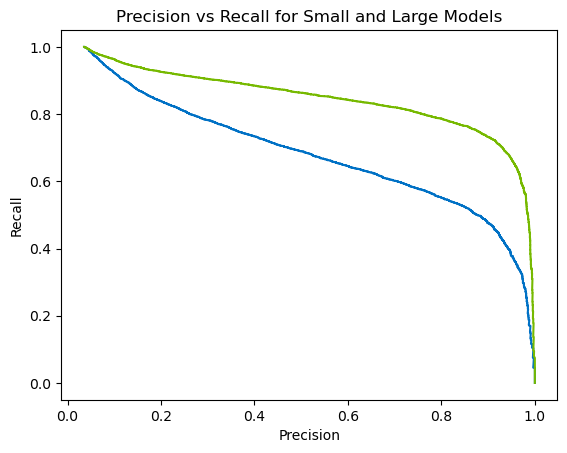

In [53]:
plt.plot(small_precision, small_recall, color='#0071c5')
plt.plot(large_precision, large_recall, color='#76b900')
plt.title('Precision vs Recall for Small and Large Models')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.show()

As we can see, the larger, more sophisticated model dominates the smaller model all along this curve. By deploying our model on GPU, we can identify a far greater proportion of actual fraud incidents with fewer false positives, all without going over our latency budget.

In [54]:
# Shut down the server
!docker rm -f tritonserver

tritonserver


## Conclusion
In this example notebook, we showed how to deploy an XGBoost model in Triton using the new FIL backend. While it is possible to deploy these models on both CPU and GPU in Triton, GPU-deployed models offer far higher throughput at lower latency. As a result, we can deploy more sophisticated models on the GPU for any given latency budget and thereby obtain far more accurate results.

While we have focused on XGBoost in this example, FIL also natively supports LightGBM's text serialization format as well as Treelite's checkpoint format. Thus, the same general steps can be used to serve LightGBM models and any Treelite-convertible model (including Scikit-Learn and cuML forest models). With the new FIL backend, Triton is now ready to serve forest models of all kinds in production, whether on their own or in concert with any of the deep-learning models supported by Triton.